In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import root

In [2]:
file = 'ttbar.root'
df = ROOT.RDataFrame("Events", file)

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [3]:
# Define scuared generator weight to help compute error bars 
df = df.Define("genWeight2", "pow(genWeight, 2)")

In [4]:
# Function to if event has BHadrons
LeadHadron ="""
pair<int, float> LeadHadron(
ROOT::RVec<int> FlavourID, 
ROOT::RVec<float> ParticlePt)
{
    int nPart = FlavourID.size();
    int LeadId = 0;
    float LeadPt = 0.0;

    // Loop through particles
    for (int idx = 0; idx < nPart; idx++){
        int CandVal = FlavourID[idx];
        float CandPt = ParticlePt[idx];

        // Check if the particle is B hadron
        if ((abs(CandVal) >= 100 ) && (CandPt > LeadPt)){
            LeadId = CandVal;
            LeadPt = CandPt;
        }
    }
    return std::make_pair(LeadId, LeadPt);
}

"""

ROOT.gInterpreter.Declare(LeadHadron)

True

In [5]:
# Making a function to find b hadrons, since declaring std::vector breaks the backend somehow...
find_b_hadrons = """
bool FindB(
int LeadHadron_pdgId
){
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};
bool IsMeson = std::find(Mesons.begin(), Mesons.end(), LeadHadron_pdgId) != Mesons.end();
bool IsBaryon = (LeadHadron_pdgId >= 5000 && LeadHadron_pdgId < 6000);
bool BExists = IsMeson || IsBaryon;
return BExists;
}
"""
ROOT.gInterpreter.Declare(find_b_hadrons)

True

In [6]:
# Define the leading hadron pdgId and pt if it includes b quark 
df = (df.Define("LeadHadron", "LeadHadron(GenPart_pdgId, GenPart_pt)")
        .Define("LeadHadron_pdgId", "LeadHadron.first")
        .Define("LeadHadron_pt", "LeadHadron.second")
        .Define("HasB", "FindB(LeadHadron_pdgId)"))

In [7]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
semileptonic_decay = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> SemileptonicDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if ((abs(Flavour) == 13) || (abs(Flavour) == 11)){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""
ROOT.gInterpreter.Declare(semileptonic_decay)

True

In [8]:
# Track the decay chains
df = (df.Define("Semileptonic", "SemileptonicDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt)")
        .Define("SemileptonicBHadronChain_pdgId", "Semileptonic.first")
        .Define("SemileptonicBHadronChain_LeadPart", "Semileptonic.second")
        .Define("SemileptonicBHadronChain_LeadId", "SemileptonicBHadronChain_LeadPart.second")
        .Define("SemileptonicBHadronChain_pt", "SemileptonicBHadronChain_LeadPart.first"))

In [9]:
# Create dataframes for reference values

df_Bp = df.Filter("LeadHadron_pdgId == -521 || LeadHadron_pdgId == -523", "Filter plus meson")
df_B0 = df.Filter("LeadHadron_pdgId == -511 || LeadHadron_pdgId == -513", "Filter neutral meson")
df_Bs = df.Filter("LeadHadron_pdgId == -531 || LeadHadron_pdgId == -533", "Filter strange meson")
df_BL = df.Filter("LeadHadron_pdgId == 5122", "Filter Lambda")
df_BHad = df.Filter("HasB", "Filter events with B hadron")

In [10]:
# Create a dataframe for events with lead hadron decaying semileptonically
df_BHad_SL = (df.Filter("SemileptonicBHadronChain_pt > 0", "Filter events with semileptonic BHadron decay")
                .Filter("(SemileptonicBHadronChain_LeadId == LeadHadron_pdgId) && (abs(SemileptonicBHadronChain_pt - LeadHadron_pt) < 10e-5)", "Filter semileptonic decays from the lead hadron"))
                

In [12]:
# Checks if there is intermediate charm or anticharm hadron in decay chain 
# 0 = direct
# 1 = charm 
# 2 = anti-charm
# 3 = tau
# Old version, includes intermediate particles
decay_filter = """
bool DecayFilter(
ROOT::RVec<ROOT::RVec<int>> DecayChains,
int DecayChannel
){
int nChains = DecayChains.size();
int Flavour;
int Lepton;
std::vector<int> pDMesons = {411, 413, 421, 423, 431, 433};
std::vector<int> nDMesons = {-411, -413, -421, -423, -431, -433};
std::vector<int> bMesons = {-511, -513, -521, -523, -531, -533};
bool IsMuon = false;
bool IsMeson = false;
bool IsHadron = false;
ROOT::RVec<int> DecayChain;





//direct
if (DecayChannel == 0){
    for (int ii = 0; ii < nChains; ii++){
        DecayChain = DecayChains[ii];
        Lepton = DecayChain[0];
        Flavour = DecayChain[1];

        IsMuon = abs(Lepton) == 13;
        IsMeson = std::find(bMesons.begin(), bMesons.end(), Flavour) != bMesons.end();
        IsHadron = IsMeson || (Flavour >= 5000 && Flavour < 6000);
        if (IsMuon && IsHadron){
            return true;
        }
    }
}

// charm
if (DecayChannel == 1){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        int nPart = DecayChain.size();
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        for (int ii = 0; ii < nPart; ii++){
            Flavour = DecayChain[ii];
            IsMeson = std::find(pDMesons.begin(), pDMesons.end(), Flavour) != pDMesons.end();
            IsHadron = IsMeson || (Flavour >= 4000 && Flavour < 5000);
            if (IsMuon && IsHadron){
                return true;
            }
        }
    }
}


// anti-charm
if (DecayChannel == 2){
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        int nPart = DecayChain.size();
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        for (int ii = 0; ii < nPart; ii++){
            Flavour = DecayChain[ii];
            IsMeson = std::find(nDMesons.begin(), nDMesons.end(), Flavour) != nDMesons.end();
            IsHadron = IsMeson || (Flavour <= -4000 && Flavour > -5000);
            if (IsMuon && IsHadron){
                return true;
            }
        }
    }
}


// tau
if (DecayChannel == 3){
    bool nTau;
    bool pTau;
    for (int jj = 0; jj < nChains; jj++){
        DecayChain = DecayChains[jj];
        Lepton = DecayChain[0];
        IsMuon = abs(Lepton) == 13;
        nTau = std::find(DecayChain.begin(), DecayChain.end(), -15) != DecayChain.end();
        pTau = std::find(DecayChain.begin(), DecayChain.end(), 15) != DecayChain.end();
        IsHadron = nTau || pTau;     //Misleading, but using same memoryslot for tau
        if (IsMuon && IsHadron){
            return true;
        }
    }
}


return false;
}

"""
ROOT.gInterpreter.Declare(decay_filter)

True

In [13]:
# Filtering dataframes according to the decay mode
df_BHad_SL = (df_BHad_SL.Define("Direct", "DecayFilter(SemileptonicBHadronChain_pdgId, 0)")
                        .Define("Charm", "DecayFilter(SemileptonicBHadronChain_pdgId, 1)")
                        .Define("AntiCharm", "DecayFilter(SemileptonicBHadronChain_pdgId, 2)")
                        .Define("Tau", "DecayFilter(SemileptonicBHadronChain_pdgId, 3)"))

df_direct = df_BHad_SL.Filter("Direct")
df_charm = df_BHad_SL.Filter("Charm")
df_anticharm = df_BHad_SL.Filter("AntiCharm")
df_tau = df_BHad_SL.Filter("Tau")

In [15]:
# More detailed filtering for the scaling factors
df_direct_only = df_direct.Filter("!Charm && !AntiCharm && !Tau")
df_tau_only = df_tau.Filter("!Direct && !Charm && !AntiCharm")
df_charm_only = df_charm.Filter("!Direct && !AntiCharm && !Tau")
df_anticharm_only = df_anticharm.Filter("!Direct && !Charm && !Tau")

df_direct_charm = df_charm.Filter("Direct && !Tau && !AntiCharm")
df_direct_anticharm = df_anticharm.Filter("Direct && !Tau && !Charm")
df_tau_anticharm = df_tau.Filter("AntiCharm && !Direct&& !Charm")
df_tau_charm = df_tau.Filter("Charm && !AntiCharm && !Direct")
df_charm_anticharm = df_anticharm.Filter("Charm && !Tau && !Direct")

In [16]:
# Filter events that decay semileptonically from specific meson or baryon
df_charged_mesons = df_direct.Filter("LeadHadron_pdgId == -521 || LeadHadron_pdgId == -523", "Filter decays from charged mesons")
df_uncharged_mesons = df_direct.Filter("LeadHadron_pdgId == -511 || LeadHadron_pdgId == -513", "Filter decays from uncharged mesons")
df_strange_mesons = df_direct.Filter("LeadHadron_pdgId == -531 || LeadHadron_pdgId == -533", "Filter decays from strange mesons")
df_Lambda = df_direct.Filter("LeadHadron_pdgId == 5122", "Filter decays from Lambda")

In [17]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
inclusive_decay = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> InclusiveDecay(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt,
int MesonFlavour
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if (abs(Flavour) == MesonFlavour){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""
ROOT.gInterpreter.Declare(inclusive_decay)

True

In [18]:
# Compute decay chains for inclusive decays
df = (df.Define("InclusiveUncharged", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 421)")
                        .Define("InclusiveUnchargedChain_pdgId", "InclusiveUncharged.first")
                        .Define("InclusiveUnchargedChain_LeadPart", "InclusiveUncharged.second")
                        .Define("InclusiveUnchargedChain_pt", "InclusiveUnchargedChain_LeadPart.first")
                        .Define("InclusiveUnchargedChain_LeadId", "InclusiveUnchargedChain_LeadPart.second"))

df = (df.Define("InclusiveCharged", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 411)")
        .Define("InclusiveChargedChain_pdgId", "InclusiveCharged.first")
        .Define("InclusiveChargedChain_LeadPart", "InclusiveCharged.second")
        .Define("InclusiveChargedChain_pt", "InclusiveChargedChain_LeadPart.first")
        .Define("InclusiveChargedChain_LeadId", "InclusiveChargedChain_LeadPart.second"))

df = (df.Define("InclusiveStrange", "InclusiveDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, 431)")
        .Define("InclusiveStrangeChain_pdgId", "InclusiveStrange.first")
        .Define("InclusiveStrangeChain_LeadPart", "InclusiveStrange.second")
        .Define("InclusiveStrangeChain_pt", "InclusiveStrangeChain_LeadPart.first")
        .Define("InclusiveStrangeChain_LeadId", "InclusiveStrangeChain_LeadPart.second"))

In [19]:
df_inclusive_uncharged = df.Filter("InclusiveUnchargedChain_pt == LeadHadron_pt && InclusiveUnchargedChain_LeadId == LeadHadron_pdgId")
df_inclusive_charged = df.Filter("InclusiveChargedChain_pt == LeadHadron_pt && InclusiveChargedChain_LeadId == LeadHadron_pdgId")
df_inclusive_strange = df.Filter("InclusiveStrangeChain_pt == LeadHadron_pt && InclusiveStrangeChain_LeadId == LeadHadron_pdgId")

In [20]:
# More specific cuts
df_inclusive_unchargedB0 = df_inclusive_uncharged.Filter("InclusiveUnchargedChain_LeadId == -511 || InclusiveUnchargedChain_LeadId == -513", "Filter decays from uncharged mesons")
df_inclusive_chargedB0 = df_inclusive_charged.Filter("InclusiveChargedChain_LeadId == -511 || InclusiveChargedChain_LeadId == -513", "Filter decays from uncharged mesons")
df_inclusive_strangeB0 = df_inclusive_strange.Filter("InclusiveStrangeChain_LeadId == -511 || InclusiveStrangeChain_LeadId == -513", "Filter decays from uncharged mesons")

df_inclusive_unchargedBp = df_inclusive_uncharged.Filter("InclusiveUnchargedChain_LeadId == -521 || InclusiveUnchargedChain_LeadId == -523", "Filter decays from charged mesons")
df_inclusive_chargedBp = df_inclusive_charged.Filter("InclusiveChargedChain_LeadId == -521 || InclusiveChargedChain_LeadId == -523", "Filter decays from charged mesons")
df_inclusive_strangeBp = df_inclusive_strange.Filter("InclusiveStrangeChain_LeadId == -521 || InclusiveStrangeChain_LeadId == -523", "Filter decays from charged mesons")

In [21]:
# More specific cuts
df_inclusive_unchargedB0 = (df_inclusive_unchargedB0.Define("cMesons", "InclusiveUnchargedChain_pdgId.size()")
                                                    .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_chargedB0 = (df_inclusive_chargedB0.Define("cMesons", "InclusiveChargedChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_strangeB0 = (df_inclusive_strangeB0.Define("cMesons", "InclusiveStrangeChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))

df_inclusive_unchargedBp = (df_inclusive_unchargedBp.Define("cMesons", "InclusiveUnchargedChain_pdgId.size()")
                                                    .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_chargedBp = (df_inclusive_chargedBp.Define("cMesons", "InclusiveChargedChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))
df_inclusive_strangeBp = (df_inclusive_strangeBp.Define("cMesons", "InclusiveStrangeChain_pdgId.size()")
                                                .Define("InclusiveWeight", "cMesons * genWeight"))

In [22]:
# Loop through semileptonic decay chains returns pair of flavours within decay chain and BHadron pt for binning 
# Only computed from largest hadron
inclusive_decay_charge = """
pair<ROOT::RVec<ROOT::RVec<int>>, pair<float, int>> InclusiveDecayCharge(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::VecOps::RVec<UShort_t> statusFlags,
ROOT::RVec<float> PartPt,
int MesonFlavour
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};


// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];

    // If the particle is lepton
    if (Flavour == MesonFlavour){


        // Initialize the while loop
        int Idx = ii;
        bool IsMeson = false;
        bool IsBHadron = false;
        ROOT::RVec<int> CandVector;
        CandVector.push_back(Flavour);
        bool FromHardProcess = (statusFlags[Idx] >> 8) & 1;

        int Mother = MotherIdx[Idx];
        int MotherFlavour = ParticleFlavour[Mother];
        bool MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
        bool MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));


        // Trace back the decay chain
        while ((!IsBHadron || (IsBHadron && MotherIsBHadron)) && !FromHardProcess && Idx != -1){
            Idx = Mother;
            Flavour = ParticleFlavour[Idx];
            CandVector.push_back(Flavour);
            IsMeson = MotherIsMeson;
            IsBHadron = MotherIsBHadron;
            FromHardProcess = (statusFlags[Idx] >> 8) & 1;
        
            // Include excited states (check that mother is not b hadron)
            Mother = MotherIdx[Idx];
            if (Mother < 0 || Mother >= nParticles) { 
                MotherIsMeson = false;
                MotherIsBHadron = false;
                break;
            }
            MotherFlavour = ParticleFlavour[Mother];
            MotherIsMeson = std::find(Mesons.begin(), Mesons.end(), MotherFlavour) != Mesons.end();
            MotherIsBHadron = (MotherIsMeson || (MotherFlavour >= 5000 && MotherFlavour < 6000));      

        }

        // Check if the decay chain is from BHadron
        if (IsBHadron){
            float CandPt = PartPt[Idx];

            // Update the return values if the initial hadron has higher pt than the previous one
            if (CandPt > ReturnPt){
                ReturnVector.clear();
                ReturnVector.push_back(CandVector);
                ReturnPt = CandPt;
                Return_pdgId = CandVector.back();
            }
            else if (CandPt == ReturnPt && CandVector.back() == Return_pdgId){
                ReturnVector.push_back(CandVector);
            }
        }
    }
}

pair <float, int> LeadHadron = std::make_pair(ReturnPt, Return_pdgId);
return std::make_pair(ReturnVector, LeadHadron);

}

"""
ROOT.gInterpreter.Declare(inclusive_decay_charge)

True

In [23]:
# Define filtering conditions for inclusive decay to negative strange d meson
df = (df.Define("InclusiveNegStrange", "InclusiveDecayCharge(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_statusFlags, GenPart_pt, -431)")
        .Define("InclusiveNegStrangeChain_pdgId", "InclusiveNegStrange.first")
        .Define("InclusiveNegStrangeChain_LeadPart", "InclusiveNegStrange.second")
        .Define("InclusiveNegStrangeChain_pt", "InclusiveNegStrangeChain_LeadPart.first")
        .Define("InclusiveNegStrangeChain_LeadId", "InclusiveNegStrangeChain_LeadPart.second"))

In [24]:
# Filter accordingly
df_inclusive_strange_neg = (df.Filter("InclusiveNegStrangeChain_pt == LeadHadron_pt && InclusiveNegStrangeChain_LeadId == LeadHadron_pdgId", "Filter decays to strange negative mesons")
                            .Filter("InclusiveNegStrangeChain_LeadId == -531 || InclusiveNegStrangeChain_LeadId == -533", "Filter decays from charged mesons"))
df_inclusive_strange_neg = (df_inclusive_strange_neg.Define("cMesons", "InclusiveNegStrangeChain_pdgId.size()")
                                                    .Define("InclusiveWeight", "cMesons * genWeight"))


In [26]:
# Create dataframes for reference values

df_Bp = df.Filter("LeadHadron_pdgId == -521 || LeadHadron_pdgId == -523", "Filter plus meson")
df_B0 = df.Filter("LeadHadron_pdgId == -511 || LeadHadron_pdgId == -513", "Filter neutral meson")
df_Bs = df.Filter("LeadHadron_pdgId == -531 || LeadHadron_pdgId == -533", "Filter strange meson")
df_BL = df.Filter("LeadHadron_pdgId == 5122", "Filter Lambda")
df_BHad = df.Filter("HasB", "Filter events with B hadron")

In [27]:
# More detailed dataframes for inclusive decays
df_inclusiveB0_p_only = df_B0.Filter("InclusiveUnchargedChain_pt == 0 && InclusiveChargedChain_pt > 0 && InclusiveStrangeChain_pt == 0 ") 
df_inclusiveB0_p0 = df_B0.Filter("InclusiveUnchargedChain_pt > 0 && InclusiveChargedChain_pt > 0 && InclusiveStrangeChain_pt == 0 ") 
df_inclusiveB0_ps = df_B0.Filter("InclusiveUnchargedChain_pt == 0 && InclusiveChargedChain_pt > 0 && InclusiveStrangeChain_pt > 0 ") 

df_inclusiveB0_0_only = df_B0.Filter("InclusiveUnchargedChain_pt > 0 && InclusiveChargedChain_pt == 0 && InclusiveStrangeChain_pt == 0 ") 
df_inclusiveB0_0s = df_B0.Filter("InclusiveUnchargedChain_pt > 0 && InclusiveChargedChain_pt == 0 && InclusiveStrangeChain_pt > 0 ") 

df_inclusiveB0_s_only = df_B0.Filter("InclusiveUnchargedChain_pt == 0 && InclusiveChargedChain_pt == 0 && InclusiveStrangeChain_pt > 0 ") 


df_inclusiveBp_p_only = df_Bp.Filter("InclusiveUnchargedChain_pt == 0 && InclusiveChargedChain_pt > 0 && InclusiveStrangeChain_pt == 0 ") 
df_inclusiveBp_p0 = df_Bp.Filter("InclusiveUnchargedChain_pt > 0 && InclusiveChargedChain_pt > 0 && InclusiveStrangeChain_pt == 0 ") 
df_inclusiveBp_ps = df_Bp.Filter("InclusiveUnchargedChain_pt == 0 && InclusiveChargedChain_pt > 0 && InclusiveStrangeChain_pt > 0 ") 

df_inclusiveBp_0_only = df_Bp.Filter("InclusiveUnchargedChain_pt > 0 && InclusiveChargedChain_pt == 0 && InclusiveStrangeChain_pt == 0 ") 
df_inclusiveBp_0s = df_Bp.Filter("InclusiveUnchargedChain_pt > 0 && InclusiveChargedChain_pt == 0 && InclusiveStrangeChain_pt > 0 ") 

df_inclusiveBp_s_only = df_Bp.Filter("InclusiveUnchargedChain_pt == 0 && InclusiveChargedChain_pt == 0 && InclusiveStrangeChain_pt > 0 ") 

In [28]:
# Assumes that different dataframe is created for semileptonic, individual and inclusive
class Rescale():
    def __init__(self):
        self.Total_df = None                                                            # ROOT Dataframe including all decay channels 
        self.nTotal = None                                                              # Vector containing bins of ref
        self.nTotal_w2 = None                                                           # Bin weighted with w^2 -> sum(w^2)
        self.bins = None                                                                # x value
        self.intervals = None                                                           # Array of intervals 
        self.branching_ratios = pd.DataFrame(columns=['Decay product', 'BR', 'CI'])     # DataFrame for the results

        self.nEntries_p8 = {}                                                           # For more detailed separation of decays
        self.Nonsl = None                                                               # Track decays that are not semileptonic
        self.branching_ratio_p8 = {}                                                    # Df for pt bin values 
        self.branching_ratio_pdg = {}                                                   # Df for references
        self.scaling_factors = {}                                                       # Df for scaling factors  
        self.scaling_factors_nonsl = {}                                                 # Df for other than semileptonic if not included in latter
        self.error_bars_pdg = {}                                                        # Error bars from ref value
        self.error_bars = {}                                                            # Empirical error bars
        self.colors = {}                                                                # Colors for plots

        self.histo_frame = {}




    def Branching_ratio(self, Decay_df, Name, Z=1.645):

        # Weighted sums directly from ROOT RDataFrame
        nTotal = self.Total_df.Sum("genWeight").GetValue()
        nDecay = Decay_df.Sum("genWeight").GetValue()

        # Effective number of events from weight variance
        W = self.Total_df.Sum("genWeight2").GetValue()
        Neff = nTotal**2 / W if W > 0 else 0

        # Branching ratio and confidence interval
        BR = nDecay / nTotal if nTotal > 0 else 0
        CI = Z * np.sqrt((BR * (1 - BR)) / Neff) if Neff > 0 else 0

        # Store results
        self.branching_ratios.loc[len(self.branching_ratios)] = {
            'Decay product': Name,
            'BR': BR,
            'CI': CI
        }






    def Calculate_total(self, intervals, Total_df):
        self.intervals = np.array(intervals)
        self.bins = 0.5 * (self.intervals[:-1] + self.intervals[1:])

        self.Total_df = Total_df

        h_total = Total_df.Histo1D(
            ("h_total", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight"
        )

        # Histograms for weight^2 sums
        h_total_w2 = Total_df.Histo1D(
            ("h_total_w2", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight2"
        )

        h_total = h_total.GetValue()
        h_total_w2 = h_total_w2.GetValue()
        

        self.nTotal = np.array([h_total.GetBinContent(i+1) for i in range(len(intervals)-1)])
        self.nTotal_w2 = np.array([h_total_w2.GetBinContent(i+1) for i in range(len(intervals)-1)])
        self.Nonsl = self.nTotal







    def Branching_ratio_pt(self, Decay_df, Name, Inclusive = False, nEntries = False, last = False, last_name = 'Other', Z=1.645):


        # Histograms for total and decay counts
        if Inclusive:

            h_decay = Decay_df.Histo1D(
                ("h_decay", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
                "LeadHadron_pt", "InclusiveWeight"
            )          
        else:   
            h_decay = Decay_df.Histo1D(
                ("h_decay", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
                "LeadHadron_pt", "genWeight"
            )

        h_decay = h_decay.GetValue()

        # Convert to numpy bin contents (ignore under/overflow bins)
        nDecay = np.array([h_decay.GetBinContent(i+1) for i in range(len(self.intervals)-1)])
        

        Neff = self.nTotal**2 / self.nTotal_w2
        BR = nDecay / self.nTotal
        CI = Z * np.sqrt((BR * (1 - BR)) / Neff)

        self.branching_ratio_p8[Name] = BR.tolist()
        self.error_bars[Name] = CI.tolist()


        if nEntries:
            self.Nonsl = self.Nonsl - nDecay
            self.nEntries_p8[Name] = nDecay

            if last:
                self.nEntries_p8[last_name] = self.Nonsl


    # For scaling factor studies, we need to separate individual decay paths 
    def compute_nEntries(self, Decay_df, Name, last = False, last_name = None):
        h_decay = Decay_df.Histo1D(
                ("h_decay", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
                "LeadHadron_pt", "genWeight"
            )
        
        
        h_decay = h_decay.GetValue()

        nDecay = np.array([h_decay.GetBinContent(i+1) for i in range(len(self.intervals)-1)])

        self.Nonsl = self.Nonsl - nDecay
        self.nEntries_p8[Name] = nDecay

        if last:
            if last_name == None:
                self.nEntries_p8['Non Semileptonic'] = self.Nonsl
            else:
                self.nEntries_p8[last_name] = self.Nonsl
        




    # Add reference value and corresponding color
    def add_pdgBR(self, Name, val, color):
        self.branching_ratio_pdg[Name] = val
        self.colors[Name] = color





    # Define system for scaling factors
    # Also non semileptonic have to be included in arguments!!!
    # Bins must be written as n = [l, taul, cl, cbarl, lcl, lcbarl, taulcl, taulcbarl, clcbarl, non-sl]
    # Weights must be written as x = [l, taul, cl, cbarl, non-sl]
    # Ref values f = [l, taul, cl, cbarl, non-sl]
    def semileptonic_scaling_factors(self, x, n, f):
        # c = [c_l, c_taul, c_cl, c_cbarl, c_non_sl]
        c_l, c_tl, c_cl, c_cbl, c_nsl = x

        # n = [l, taul, cl, cbarl, lcl, lcbarl, taulcl, taulcbarl, clcbarl, non_sl]
        (n_l, n_tl, n_cl, n_cbl,
        n_lcl, n_lcbl, n_tlcl, n_tlcbl, n_clcbl, n_nsl) = n

        # target fractions f = [l, taul, cl, cbarl, non-sl] (only first 4 used here)
        f_l, f_tl, f_cl, f_cbl = f

        # contributions (numerators)
        tot_l  = c_l  * (n_l  + c_cl*n_lcl  + c_cbl*n_lcbl)
        tot_tl = c_tl * (n_tl + c_cl*n_tlcl + c_cbl*n_tlcbl)
        tot_cl = c_cl * (n_cl + c_l*n_lcl   + c_tl*n_tlcl   + c_cbl*n_clcbl)
        tot_cbl= c_cbl* (n_cbl+ c_l*n_lcbl  + c_tl*n_tlcbl  + c_cl*n_clcbl)
        tot_nsl= c_nsl * n_nsl

        N_f_tot = tot_l + tot_tl + tot_cl + tot_cbl + tot_nsl
        N_i_tot = sum(n)

        return np.array([
            f_l  - tot_l  / N_f_tot,
            f_tl - tot_tl / N_f_tot,
            f_cl - tot_cl / N_f_tot,
            f_cbl- tot_cbl/ N_f_tot,
            N_i_tot - N_f_tot
        ])

        




    # Assumes branching ratios are computed beforehand and pdg values added
    def compute_sl_scaling_factors(self):
        
        ref_names = list(self.branching_ratio_pdg.keys())
        n_vals = np.array(list(self.nEntries_p8.values()))
        f = np.array(list(self.branching_ratio_pdg.values())).flatten()
        print(ref_names)

        scaling_factors = np.zeros((5, len(self.bins)))

        if n_vals.shape[0] != 10: 
            print("Wrong shape!")

        x0 = [1,1,1,1,1]
        for ii in range(len(self.bins)):
            n = n_vals[:, ii].flatten()
            sol = root(self.semileptonic_scaling_factors, x0, args = (n, f))
            value = sol.x

            scaling_factors[:, ii] = value
            
        for jj in range(4):
            self.scaling_factors[ref_names[jj]] = scaling_factors[jj,:].tolist()


        # Append scaling factors into a 
        with open('scaling_factors.txt', 'a') as f:
            for key, val_list in self.scaling_factors.items():
                val_str = ','.join(map(str, val_list))
                f.write(f"{key}: {val_str}\n")

        with open('scaling_factors.txt', 'a') as f:
            val_str = ','.join(map(str, list(self.intervals)))
            val_nsl = ','.join(map(str, list(scaling_factors[4,:])))
            f.write(f'Non semileptonic: {val_nsl}\n')
            f.write(f'Intervals: {val_str}\n')

 



    # Scaling factors for individual decays
    def compute_ind_scaling_factors(self, ref_names = None, Inclusive = False):

        if Inclusive:
            list_names = ref_names
        else:
            list_names = self.nEntries_p8.keys()

        for ii, ch in enumerate(list_names):
            ci =  self.branching_ratio_pdg[ch] / np.array(self.branching_ratio_p8[ch])
            ci_nonsl =  (1 - self.branching_ratio_pdg[ch]) / np.array(self.branching_ratio_p8[ch])

            self.scaling_factors[ch] = ci
            self.scaling_factors_nonsl[ch] = ci_nonsl

        # Append scaling factors into text file 
        with open('scaling_factors.txt', 'a') as f:
            for key, val_list in self.scaling_factors.items():
                val_str = ','.join(map(str, val_list))
                f.write(f"{key}: {val_str}\n")

        # Append nonsl scaling factors into text file
        with open('scaling_factors.txt', 'a') as f:
            for key, val_list in self.scaling_factors_nonsl.items():
                key_nonsl = key + '_non_sl'
                val_str = ','.join(map(str, val_list))
                f.write(f"{key_nonsl}: {val_str}\n")

        with open('scaling_factors.txt', 'a') as f:
            val_str = ','.join(map(str, list(self.intervals)))
            f.write(f'Intervals: {val_str}\n')



    # Define system for scaling factors
    # Also other have to be included in arguments!!!
    # Bins must be written as n = [+, 0, s, +0, +s, 0s, other]
    # Weights must be written as c = [+, 0, s, other]
    # Ref values f = [+, 0, s]
    def inclusive_scaling_factors(self, x, n, f):
        # Scaling factors
        c_plus, c_zero, c_s, c_other = x

        # Bins: n = [+, 0, s, +0, +s, 0s, other]
        (n_plus, n_zero, n_s, n_p0, n_ps, n_0s, n_other) = n

        # Target fractions f = [f+, f0, fs] (other not constrained by fraction)
        f_plus, f_zero, f_s = f

        # Contributions (numerators, following Eq. A.7 / A.9)
        tot_plus = c_plus * (n_plus + c_zero*n_p0 + c_s*n_ps)
        tot_zero = c_zero * (n_zero + c_plus*n_p0 + c_s*n_0s)
        tot_s    = c_s    * (n_s    + c_plus*n_ps + c_zero*n_0s)
        tot_other= c_other * n_other

        N_f_tot = tot_plus + tot_zero + tot_s + tot_other
        N_i_tot = sum(n)

        return np.array([
            f_plus - tot_plus / N_f_tot,
            f_zero - tot_zero / N_f_tot,
            f_s    - tot_s    / N_f_tot,
            N_i_tot - N_f_tot
        ])




    # Scaling factors for inclusive decays
    def compute_inclusive_scaling_factors(self, ref_names, other_names, name):

        n_vals = np.array([self.nEntries_p8[k] for k in ref_names])
        f = np.array([self.branching_ratio_pdg[k] for k in other_names]).flatten()   #Remove other from names

        scaling_factors = np.zeros((4, len(self.bins)))

        if n_vals.shape[0] != 7: 
            print("Wrong shape!")

        x0 = [1,1,1,1]
        for ii in range(len(self.bins)):
            n = n_vals[:, ii].flatten()
            sol = root(self.inclusive_scaling_factors, x0, args = (n, f))
            value = sol.x

            scaling_factors[:, ii] = value
            
        for jj in range(3):
            self.scaling_factors[other_names[jj]] = scaling_factors[jj,:].tolist()


        # Append scaling factors into text file
        with open('scaling_factors.txt', 'a') as f:
            for key, val_list in self.scaling_factors.items():
                val_str = ','.join(map(str, val_list))
                f.write(f"{key}: {val_str}\n")

        with open('scaling_factors.txt', 'a') as f:
            val_str = ','.join(map(str, list(self.intervals)))
            val_nsl = ','.join(map(str, list(scaling_factors[3, :])))
            f.write(f'Other {name}: {val_str}\n')
            f.write(f'Intervals: {val_str}\n')



    # Plotting the results
    def plot_results(self, ylim, Names = None, plot_all = True):
        hep.style.use("CMS")

        if plot_all:
            keys = self.branching_ratio_p8.keys()
        else:
            keys = Names
        # Bin widths for xerr
        x_error = 0.5 * (self.intervals[1:] - self.intervals[:-1])


        # Plot for branching ratios (figure 1)
        fig1, ax1 = plt.subplots(figsize=(7, 5))

        for ch in keys:
            br_vals = np.array(self.branching_ratio_p8[ch])
            br_errs = np.array(self.error_bars[ch])
            pdg_vals = np.array(self.branching_ratio_pdg[ch])

            ax1.errorbar(
                self.bins, br_vals,
                yerr=br_errs, xerr=x_error,
                fmt="o", color=self.colors[ch], label=f"{ch} P8",
                markersize = 3, lw = 0.8
            )

            if pdg_vals.size == 1:
                ax1.axhline(pdg_vals, linestyle="--", color=self.colors[ch], alpha=0.7, label=f"{ch} PDG", lw = 0.8)
            else:
                ax1.plot(self.bins, pdg_vals, linestyle="--", color=self.colors[ch], alpha=0.7, label=f"{ch} PDG", lw = 0.8)

        ax1.set_xscale("log")
        ax1.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax1.set_ylabel("Branching ratio", fontsize = 10)
        ax1.legend(fontsize=9)
        ax1.set_ylim(ylim[0], ylim[1])

        ax1.tick_params(axis='both', which='major', labelsize=8)  
        ax1.tick_params(axis='both', which='minor', labelsize=6)

        plt.tight_layout()
        plt.show()

        # Plot for scaling factors (figure 2)
        fig2, ax2 = plt.subplots(figsize=(7, 5))

        # Remember to compute error bars
        for ch in keys:
            sf_vals = np.array(self.scaling_factors[ch])
            ax2.errorbar(
                self.bins, sf_vals,
                yerr=0.05, xerr=x_error,
                fmt="o", color=self.colors[ch], label=ch,
                markersize = 3, lw = 0.8
            )
            ax2.axhline(1.0, linestyle="--", color=self.colors[ch], alpha=0.3, lw = 0.8)

        ax2.set_xscale("log")
        ax2.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax2.set_ylabel("Scaling factor", fontsize = 10)
        ax2.legend(fontsize=9)
        ax2.set_ylim(0, 2)

        ax2.tick_params(axis='both', which='major', labelsize=8)  
        ax2.tick_params(axis='both', which='minor', labelsize=6)

        plt.tight_layout()
        plt.show()







In [29]:
# Create pandas dataframe for the semileptonic branching ratios
intervals = np.concatenate((
    np.linspace(0, 5, 2),
    np.linspace(10, 200, 18),
    np.logspace(np.log10(250), np.log10(1000), 5)
))


semileptonic = Rescale()
semileptonic.Calculate_total(intervals, df_BHad) 

#semileptonic.Branching_ratio(df_BHad_SL, "b→µ/e")
#semileptonic.Branching_ratio(df_tau, "b→τ →µ/e ")
#semileptonic.Branching_ratio(df_charm, "b→c→µ/e")
#semileptonic.Branching_ratio(df_anticharm, "b→¯c→µ/e")

# Create plots for semileptonic

semileptonic.Branching_ratio_pt(df_direct, r'$b \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(df_tau, r'$b \rightarrow \tau \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(df_charm, r'$b \rightarrow c \rightarrow \mu / e$')
semileptonic.Branching_ratio_pt(df_anticharm, r'$b \rightarrow \bar{c} \rightarrow \mu / e$')


semileptonic.add_pdgBR(r'$b \rightarrow \mu / e$', 0.1069, 'red')
semileptonic.add_pdgBR(r'$b \rightarrow \tau \rightarrow \mu / e$', 0.0045, 'blue')
semileptonic.add_pdgBR(r'$b \rightarrow c \rightarrow \mu / e$', 0.0802, 'green')
semileptonic.add_pdgBR(r'$b \rightarrow \bar{c} \rightarrow \mu / e$', 0.016, 'orange')

#print(semileptonic.branching_ratios.to_string())

In [30]:
# Scaling factors

# Separate dataframes
semileptonic.compute_nEntries(df_direct_only, r'$n_{l}$')
semileptonic.compute_nEntries(df_tau_only, r'$n_{\tau l}$')
semileptonic.compute_nEntries(df_charm_only, r'$n_{cl}$')
semileptonic.compute_nEntries(df_anticharm_only, r'$n_{\bar{charm}l}$')
semileptonic.compute_nEntries(df_direct_charm, r'$n_{l,cl}$')
semileptonic.compute_nEntries(df_direct_anticharm, r'$n_{l,\bar{c}l}$')
semileptonic.compute_nEntries(df_tau_charm, r'$n_{\tau l, cl}$')
semileptonic.compute_nEntries(df_tau_anticharm, r'$n_{\tau l, \bar{c}l}$')
semileptonic.compute_nEntries(df_charm_anticharm, r'$n_{cl, \bar{c}l}$', last=True)

# Execute 
semileptonic.compute_sl_scaling_factors()

['$b \\rightarrow \\mu / e$', '$b \\rightarrow \\tau \\rightarrow \\mu / e$', '$b \\rightarrow c \\rightarrow \\mu / e$', '$b \\rightarrow \\bar{c} \\rightarrow \\mu / e$']


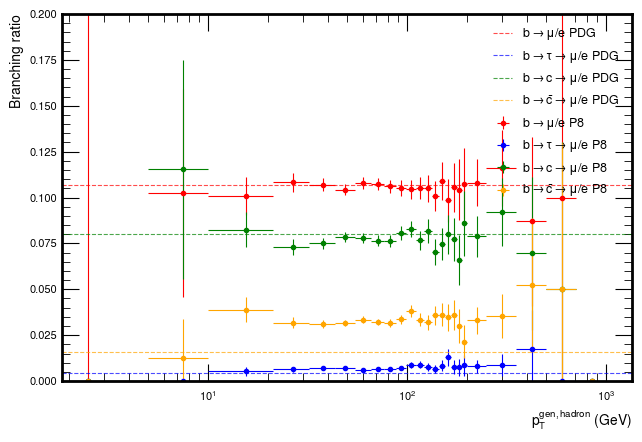

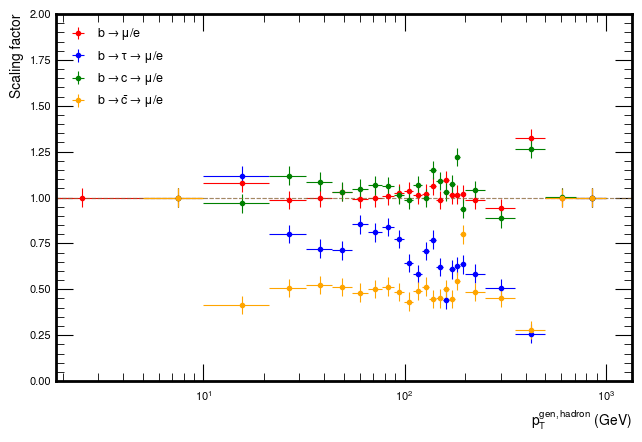

In [31]:
semileptonic.plot_results((0, 0.2))

In [32]:
# Pandas dataframe for the specific hadrons
semileptonic_ind = Rescale()

semileptonic_ind.Calculate_total(intervals, df_B0) 
#semileptonic_ind.Branching_ratio(df_uncharged_mesons, 'B0')
semileptonic_ind.Branching_ratio_pt(df_uncharged_mesons, r'$B^0 \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$B^0 \rightarrow \mu / e$', 0.1099, 'red')

semileptonic_ind.Calculate_total(intervals, df_Bp) 
#semileptonic_ind.Branching_ratio(df_charged_mesons, 'Bpm')
semileptonic_ind.Branching_ratio_pt(df_charged_mesons, r'$B^\pm \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$B^\pm \rightarrow \mu / e$', 0.1033, 'blue')

semileptonic_ind.Calculate_total(intervals, df_Bs) 
#semileptonic_ind.Branching_ratio(df_strange_mesons, 'Bs')
semileptonic_ind.Branching_ratio_pt(df_strange_mesons, r'$B^0_s \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$B^0_s \rightarrow \mu / e$', 0.096, 'green')

semileptonic_ind.Calculate_total(intervals, df_BL) 
#semileptonic_ind.Branching_ratio(df_Lambda, 'L')
semileptonic_ind.Branching_ratio_pt(df_Lambda, r'$\Lambda^0_s \rightarrow \mu / e$')
semileptonic_ind.add_pdgBR(r'$\Lambda^0_s \rightarrow \mu / e$', 0.109, 'orange')

#semileptonic_individual = semileptonic_ind.branching_ratios
#print(semileptonic_individual.to_string())

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_10259/2089307266.py:105: RuntimeWarning: invalid value encountered in divide
  Neff = self.nTotal**2 / self.nTotal_w2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_10259/2089307266.py:106: RuntimeWarning: invalid value encountered in divide
  BR = nDecay / self.nTotal


In [33]:
semileptonic_ind.compute_nEntries(df_B0, r'$B^0 \rightarrow \mu / e$')
semileptonic_ind.compute_nEntries(df_Bp, r'$B^\pm \rightarrow \mu / e$')
semileptonic_ind.compute_nEntries(df_Bs, r'$B^0_s \rightarrow \mu / e$')
semileptonic_ind.compute_nEntries(df_BL, r'$\Lambda^0_s \rightarrow \mu / e$')

semileptonic_ind.compute_ind_scaling_factors()

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_10259/2089307266.py:244: RuntimeWarning: divide by zero encountered in divide
  ci =  self.branching_ratio_pdg[ch] / np.array(self.branching_ratio_p8[ch])
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_10259/2089307266.py:245: RuntimeWarning: divide by zero encountered in divide
  ci_nonsl =  (1 - self.branching_ratio_pdg[ch]) / np.array(self.branching_ratio_p8[ch])


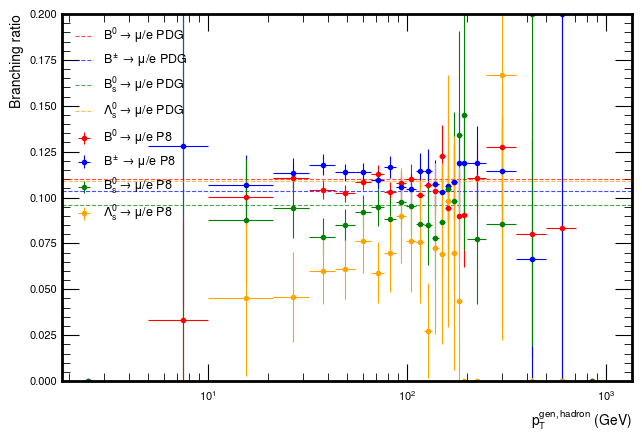

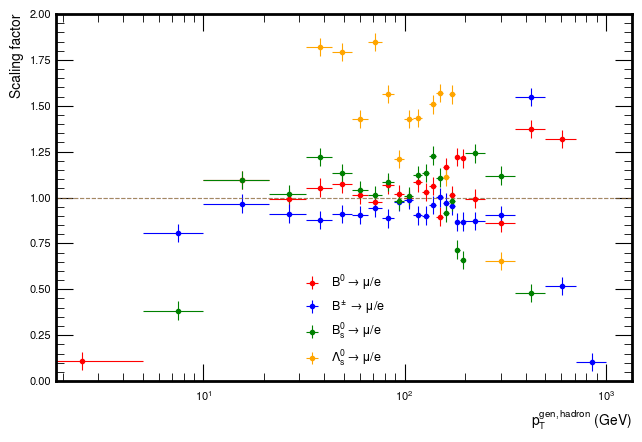

In [34]:
# Plots for specific hadrons
semileptonic_ind.plot_results((0,0.2))

In [35]:
inclusive = Rescale()

# INclusive decay from B0
inclusive.Calculate_total(intervals, df_B0) 
#inclusive.Branching_ratio(df_inclusive_strangeB0, "B0 →D+s /D−")
inclusive.Branching_ratio_pt(df_inclusive_strangeB0, r'$B^0 \rightarrow D^+_s / D^-_s$', Inclusive=True)


inclusive.add_pdgBR(r'$B^0 \rightarrow D^+_s / D^-_s$', 0.103, "red")

#inclusive.Branching_ratio(df_inclusive_unchargedB0, "B0 →D0/D0")
#inclusive.Branching_ratio(df_inclusive_chargedB0, "B0 →D+/D−")

inclusive.Branching_ratio_pt(df_inclusive_unchargedB0, r'$B^0 \rightarrow D^0 / \bar{D}^0$', Inclusive=True)
inclusive.Branching_ratio_pt(df_inclusive_chargedB0, r'$B^0 \rightarrow D^+ / D^-$', Inclusive=True, last=True, last_name=r'$Other_B^0$')

inclusive.add_pdgBR(r'$B^0 \rightarrow D^0 / \bar{D}^0$', 0.555, "green")
inclusive.add_pdgBR(r'$B^0 \rightarrow D^+ / D^-$', 0.369, "blue")

inclusive.compute_nEntries(df_inclusiveB0_0_only, r'B^0n_0')
inclusive.compute_nEntries(df_inclusiveB0_p0, r'B^0n_{+,0}')
inclusive.compute_nEntries(df_inclusiveB0_ps, r'B^0n_{+,s}')
inclusive.compute_nEntries(df_inclusiveB0_p_only, r'B^0n_+')
inclusive.compute_nEntries(df_inclusiveB0_0s, r'B^0n_{0,s}')
inclusive.compute_nEntries(df_inclusiveB0_s_only, r'B^0n_s', last=True, last_name='B0 Other')



inclusive.compute_inclusive_scaling_factors([r'B^0n_+', r'B^0n_0', r'B^0n_s', r'B^0n_{+,0}', r'B^0n_{+,s}', r'B^0n_{0,s}', 'B0 Other'], [r'$B^0 \rightarrow D^+ / D^-$', r'$B^0 \rightarrow D^0 / \bar{D}^0$', r'$B^0 \rightarrow D^+_s / D^-_s$'], 'B0')


# Inclusive decay from Bp
inclusive.Calculate_total(intervals, df_Bp)

#inclusive.Branching_ratio(df_inclusive_chargedBp, "B+ →D+/D− ")
#inclusive.Branching_ratio(df_inclusive_strangeBp, "B+ →D+s /D−s ")

inclusive.Branching_ratio_pt(df_inclusive_chargedBp, r'$B^+ \rightarrow D^+ / D^-$', Inclusive=True)
inclusive.Branching_ratio_pt(df_inclusive_strangeBp, r'$B^+ \rightarrow D^+_s / D^-_s$', Inclusive=True)

inclusive.add_pdgBR(r'$B^+ \rightarrow D^+ / D^-$', 0.124, "blue")
inclusive.add_pdgBR(r'$B^+ \rightarrow D^+_s / D^-_s$', 0.09, "green")

#inclusive.Branching_ratio(df_inclusive_unchargedBp, "B+ →D0/D0 ")

inclusive.Branching_ratio_pt(df_inclusive_unchargedBp, r'$B^+ \rightarrow D^0 / \bar{D}^0$', Inclusive=True, last=True, last_name=r'$Other_B^+$')


inclusive.add_pdgBR(r'$B^+ \rightarrow D^0 / \bar{D}^0$', 0.876, "red")

inclusive.compute_nEntries(df_inclusiveBp_0_only, r'B^+n_0')
inclusive.compute_nEntries(df_inclusiveBp_p0, r'B^+n_{+,0}')
inclusive.compute_nEntries(df_inclusiveBp_ps, r'B^+n_{+,s}')
inclusive.compute_nEntries(df_inclusiveBp_p_only, r'B^+n_+')
inclusive.compute_nEntries(df_inclusiveBp_0s, r'B^+n_{0,s}')
inclusive.compute_nEntries(df_inclusiveBp_s_only, r'B^+n_s', last=True, last_name='Bp Other')

inclusive.compute_inclusive_scaling_factors([r'B^+n_+', r'B^+n_0', r'B^+n_s', r'B^+n_{+,0}', r'B^+n_{+,s}', r'B^+n_{0,s}','Bp Other'], [r'$B^+ \rightarrow D^+ / D^-$', r'$B^+ \rightarrow D^0 / \bar{D}^0$', r'$B^+ \rightarrow D^+_s / D^-_s$'], 'Bp')

# Inclusive decay from Bs
inclusive.Calculate_total(intervals, df_Bs) 
#inclusive.Branching_ratio(df_inclusive_strange_neg, "B0s →D−[c]")
inclusive.Branching_ratio_pt(df_inclusive_strange_neg, r'$B^0_s \rightarrow D^-_s$', Inclusive=True)

inclusive.add_pdgBR(r'$B^0_s \rightarrow D^-_s$', 0.93, "orange")

inclusive.compute_ind_scaling_factors([r'$B^0_s \rightarrow D^-_s$'], Inclusive=True)


/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_10259/2089307266.py:244: RuntimeWarning: divide by zero encountered in divide
  ci =  self.branching_ratio_pdg[ch] / np.array(self.branching_ratio_p8[ch])
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_10259/2089307266.py:245: RuntimeWarning: divide by zero encountered in divide
  ci_nonsl =  (1 - self.branching_ratio_pdg[ch]) / np.array(self.branching_ratio_p8[ch])


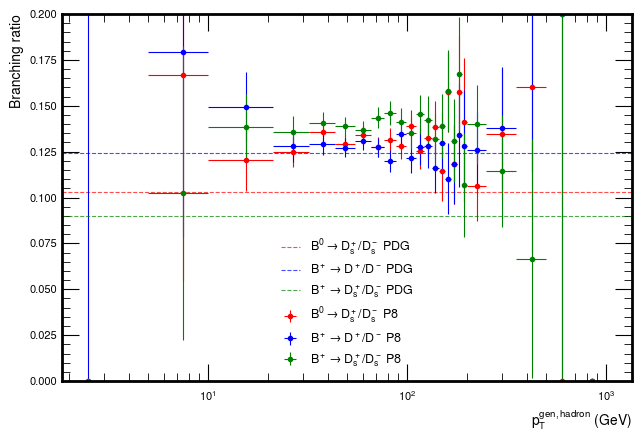

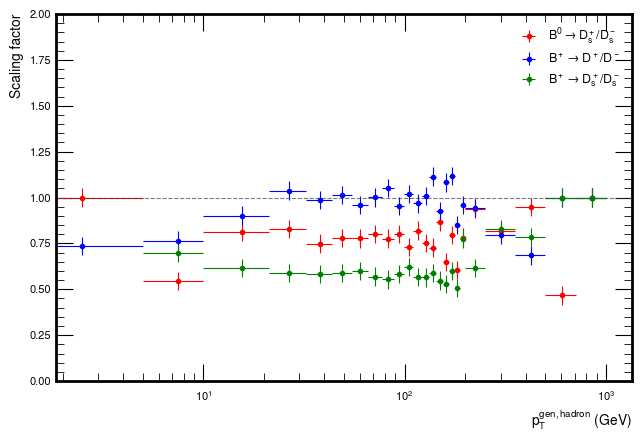

In [36]:
inclusive.plot_results((0,0.2), Names = [r'$B^0 \rightarrow D^+_s / D^-_s$', r'$B^+ \rightarrow D^+ / D^-$', r'$B^+ \rightarrow D^+_s / D^-_s$'], plot_all = False)

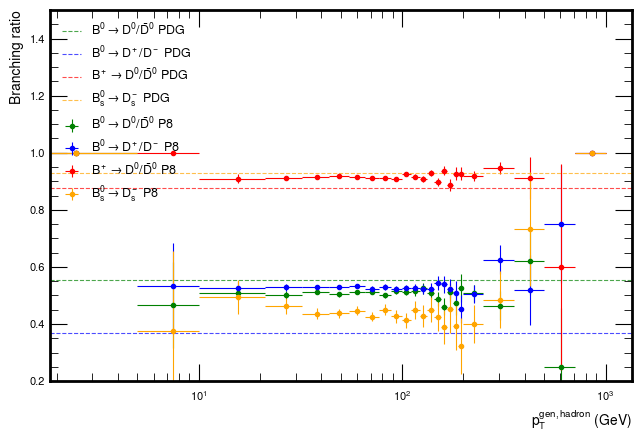

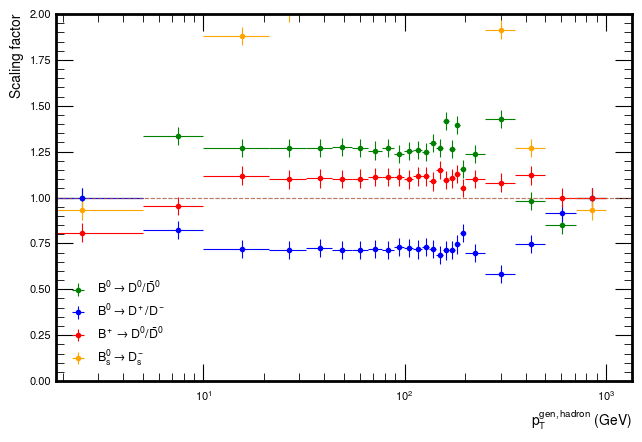

In [ ]:
inclusive.plot_results((0.2, 1.5), [r'$B^0 \rightarrow D^0 / \bar{D}^0$', r'$B^0 \rightarrow D^+ / D^-$', r'$B^+ \rightarrow D^0_s / \bar{D}^0_s$', r'$B^0_s \rightarrow D^-_s$'], plot_all=False)